In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
metadata_path = '/content/skin_data/HAM10000_metadata.csv'
images_path_1 = '/content/skin_data/HAM10000_images_part_1/'
images_path_2 = '/content/skin_data/HAM10000_images_part_2/'
output_path = '/content/dataset_split'

In [ ]:
df = pd.read_csv(metadata_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# ambil beberapa class aja yang most_common dari dx(kategori penyakit)
selected_classes = ['nv', 'mel', 'bcc', 'bkl']
df = df[df['dx'].isin(selected_classes)]

# gabungin semua gambar ke 1 folder
all_images_dir = '/content/HAM10000_all_images'
os.makedirs(all_images_dir, exist_ok=True)

for folder in [images_path_1, images_path_2]:
  for file in os.listdir(folder):
    shutil.copy(os.path.join(folder, file), all_images_dir)

In [ ]:
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(all_images_dir, x + '.jpg'))
df = df[['image_path', 'dx']]

print('Classes kept:', df['dx'].unique(), " | Total images:", len(df))

Classes kept: ['bkl' 'nv' 'mel' 'bcc']  | Total images: 9431


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# kek biasa split data ke train test val 80 10 10

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

print('Train size:', len(train_df))
print('Val size:', len(val_df))
print('Test size:', len(test_df))

Train size: 7544
Val size: 943
Test size: 944


In [ ]:
# pisahin dataset masing2 ke folder
def save_split(split_df, split_name):
    for _, row in split_df.iterrows():
        class_name = row['dx']
        img_src = row['image_path']
        split_dir = os.path.join(output_path, split_name, class_name)
        os.makedirs(split_dir, exist_ok=True)
        shutil.copy(img_src, os.path.join(split_dir, os.path.basename(img_src)))

save_split(train_df, 'train')
save_split(val_df, 'val')
save_split(test_df, 'test')

print('Dataset organized into:', output_path)

Dataset organized into: /content/dataset_split


In [ ]:
# training model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# preprocess input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(output_path, 'val'),
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(output_path, 'test'),
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7544 images belonging to 4 classes.
Found 943 images belonging to 4 classes.
Found 944 images belonging to 4 classes.


In [ ]:
# memberikan class weight untuk memberikan penalti lebih besar untuk class yang lebih rare
class_indices = train_gen.class_indices
labels = list(class_indices.keys())
print('Labels:', labels)
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y = train_gen.classes
)

class_weight_dict = dict(enumerate(class_weight))
print('Class Weights:', class_weight_dict)

Labels: ['bcc', 'bkl', 'mel', 'nv']
Class Weights: {0: np.float64(4.588807785888078), 1: np.float64(2.1456200227531284), 2: np.float64(2.1191011235955055), 3: np.float64(0.3516032811334825)}


In [ ]:
# pake model EfficientNetB0 dari google
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# freeze base modelnya biar bisa kita pake buat transfer learning
# for layer in base_model.layers:
#   layer.trainable = False

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# callback
# checkpoint_h5 = ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min'
#     )

checkpoint_tf = ModelCheckpoint(
    'best_model_tf.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
    )
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[checkpoint_tf, early_stop],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 333ms/step - accuracy: 0.4979 - loss: 1.2488 - val_accuracy: 0.7169 - val_loss: 0.7354
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 55s 231ms/step - accuracy: 0.6680 - loss: 0.9239 - val_accuracy: 0.7073 - val_loss: 0.7367
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 55s 233ms/step - accuracy: 0.6874 - loss: 0.8630 - val_accuracy: 0.7031 - val_loss: 0.7340
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 57s 241ms/step - accuracy: 0.6921 - loss: 0.8395 - val_accuracy: 0.7222 - val_loss: 0.6858
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 55s 234ms/step - accuracy: 0.6981 - loss: 0.7880 - val_accuracy: 0.7105 - val_loss: 0.7179
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 56s 239ms/step - accuracy: 0.6971 - loss: 0.7934 - val_accuracy: 0.7444 - val_loss: 0.6423
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 55s 234ms/step - accuracy: 0.7190 - loss: 0.7502 - val_accuracy: 0.7381 - val_loss: 0.6579
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 56s 237ms/step - accuracy: 0.7116 -

In [ ]:
import matplotlib.pyplot as plt

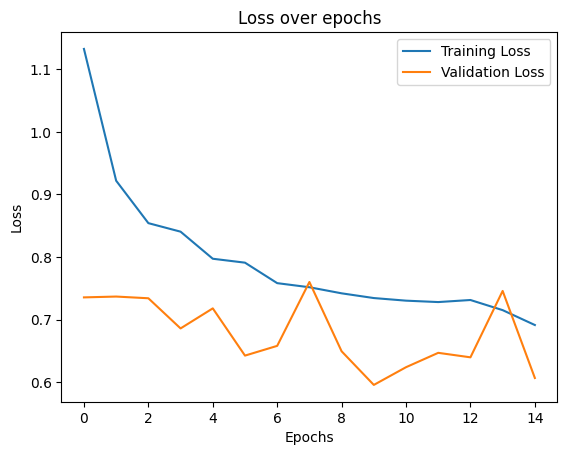

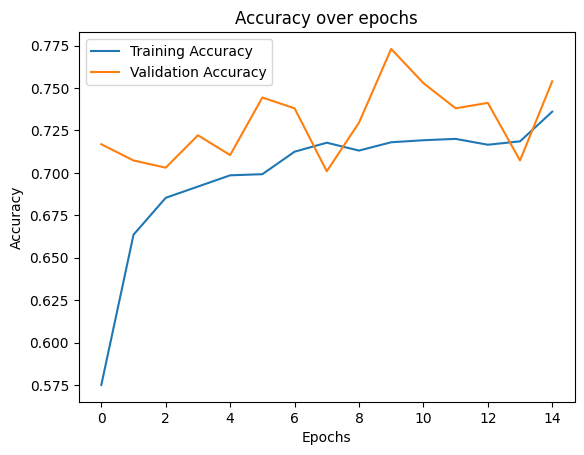

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_tf, early_stop]
)

Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 195s 492ms/step - accuracy: 0.3257 - loss: 1.4189 - val_accuracy: 0.5928 - val_loss: 1.0192
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 60s 253ms/step - accuracy: 0.4909 - loss: 1.0448 - val_accuracy: 0.6490 - val_loss: 0.9303
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 62s 262ms/step - accuracy: 0.6042 - loss: 0.8835 - val_accuracy: 0.6935 - val_loss: 0.8379
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 60s 253ms/step - accuracy: 0.6694 - loss: 0.7716 - val_accuracy: 0.7190 - val_loss: 0.7696
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 62s 263ms/step - accuracy: 0.6943 - loss: 0.7406 - val_accuracy: 0.7370 - val_loss: 0.7208
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 61s 257ms/step - accuracy: 0.7174 - loss: 0.6605 - val_accuracy: 0.7476 - val_loss: 0.6766
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 61s 256ms/step - accuracy: 0.7319 - loss: 0.6383 - val_accuracy: 0.7603 - val_loss: 0.6551
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 61s 258ms/step - accuracy: 0.7458 

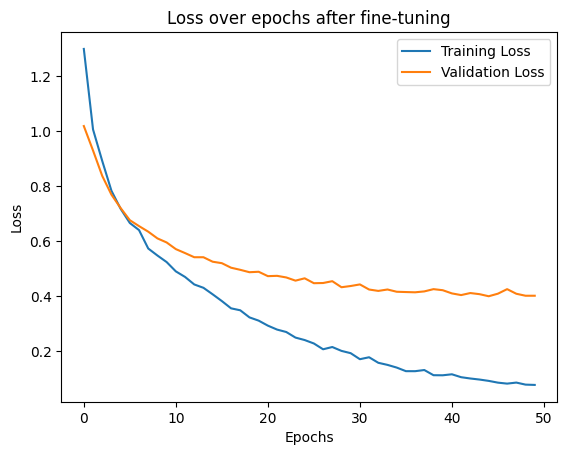

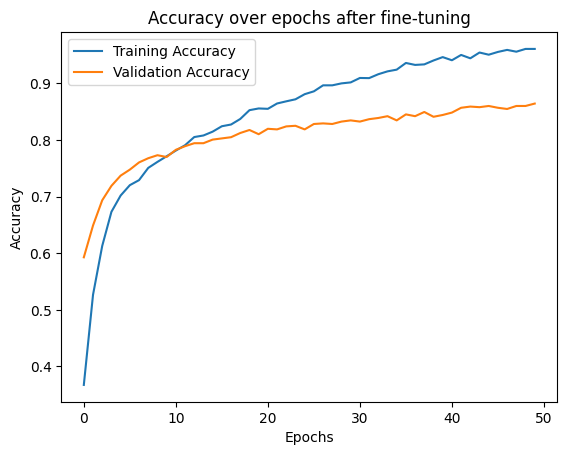

In [ ]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs after fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs after fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('./model/best_model_tf.keras')

In [ ]:
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'Test Acc: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 681ms/step - accuracy: 0.8388 - loss: 0.5105
Test Acc: 86.65%
Test Loss: 0.4062


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
y_pred_prob = model.predict(test_gen)

y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 774ms/step
              precision    recall  f1-score   support

         bcc       0.71      0.82      0.76        51
         bkl       0.70      0.85      0.77       110
         mel       0.67      0.69      0.68       112
          nv       0.95      0.90      0.93       671

    accuracy                           0.87       944
   macro avg       0.76      0.81      0.78       944
weighted avg       0.88      0.87      0.87       944



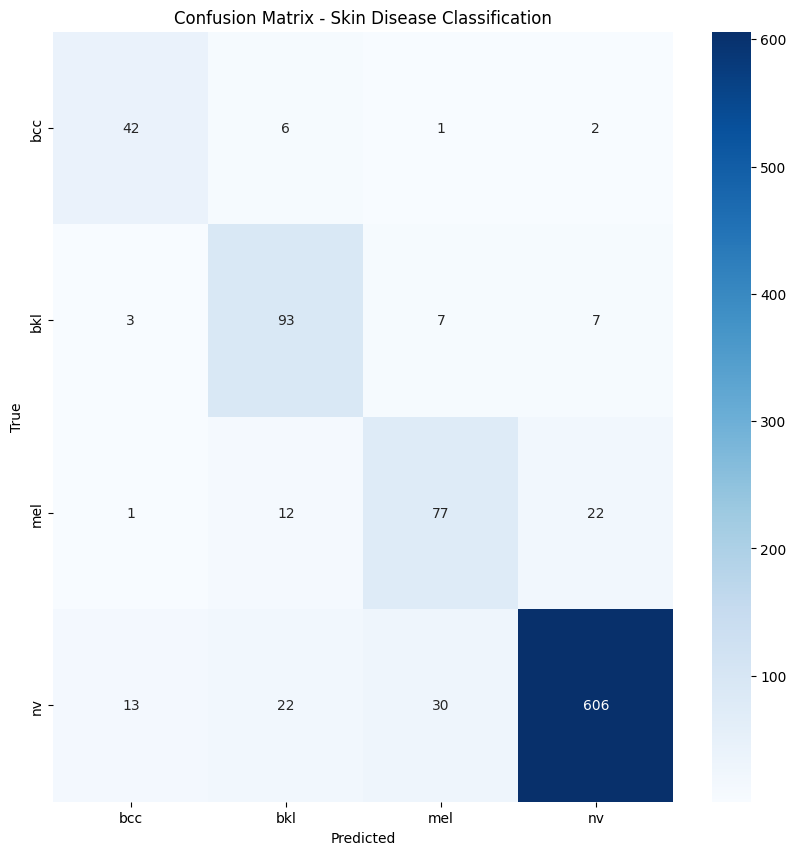

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skin Disease Classification')
plt.show()